In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt

# specify GPU
device = torch.device("cuda")

df = pd.read_csv('/content/dataset_train_updated.csv')
df.head()

,text,class
0,this boy is getting cookies outof this jar ....,0
1,well for one thing this boy's on the stool ge...,1
2,oh yes . well the mother is washing the dish...,1
3,action ? what's going on in the picture ? the...,0
4,the little boy is getting a cookie out of the...,1


In [5]:
# check class distribution
df['class'].value_counts(normalize = True)

,proportion
class,
0,0.51005
1,0.48995


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

<Axes: >

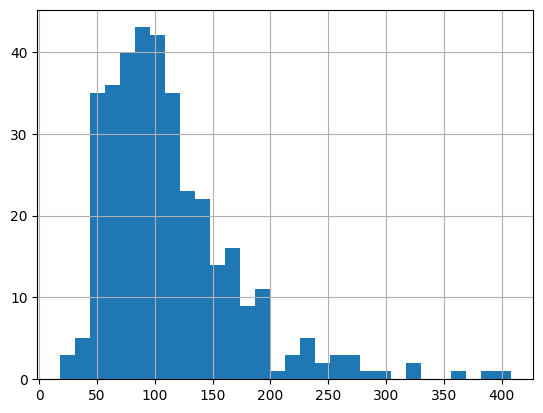

In [6]:
# split train dataset into train, validation, and tests
train_text, val_text, train_labels, val_labels = train_test_split(df['text'], df['class'],random_state=2018, test_size=0.1,stratify=df['class'])

# Load the test dataset
test_df = pd.read_csv('/content/dataset_test_updated.csv')

# Extract the test text and labels
test_text = test_df['text']
test_labels = test_df['class']

# Optional: Check the class distribution in the test data
test_df['class'].value_counts(normalize=True)

# Import bert model
bert_model = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# length of text
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [7]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
token_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 128,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

token_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 128,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

token_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 128,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

In [8]:
# convert to tensors
train_seq = torch.tensor(token_train['input_ids'])
train_mask = torch.tensor(token_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(token_val['input_ids'])
val_mask = torch.tensor(token_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(token_test['input_ids'])
test_mask = torch.tensor(token_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())


In [9]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# batch size
batch_size = 32

# wrap tensots
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during trainin
train_sampler = RandomSampler(train_data)

# dataloader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data suring training
val_sampler = SequentialSampler(val_data)

# dataloader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [10]:
# Transfer learning
for param in bert_model.parameters():
  param.requires_grad = False

In [11]:
class BERT_Arch(nn.Module):

  def __init__(self, bert):
    super(BERT_Arch, self).__init__()

    self.bert = bert

    # dropout layer
    self.dropout = nn.Dropout(0.1)

    # relu activation function
    self.relu = nn.ReLU()

    # dense layer 1
    self.fc1 = nn.Linear(768,512)

    # dense layer 2 (Output layer)
    self.fc2 = nn.Linear(512,2)

    # softmax activation function
    self.softmax = nn.LogSoftmax(dim=1)

  # define the forward
  def forward(self, sent_id, mask):

    #pass the inputs to the model
    _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

    x = self.fc1(cls_hs)

    x = self.relu(x)

    x = self.dropout(x)

    # output layer
    x = self.fc2(x)

    # apply softmax activation
    x = self.softmax(x)

    return x

In [12]:
# pass the pre-trained BERT model to our define architecture
model = BERT_Arch(bert_model)

# push the model to GPU
model = model.to(device)

In [13]:
from transformers import AdamW
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight

# define the optimizer
optimizer = optim.AdamW(model.parameters(), lr = 1e-3)

#compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

print("Class Weights: ", class_weights)

Class Weights:  [0.97814208 1.02285714]


In [14]:
# converting list of class weights to a tensor
weights = torch.tensor(class_weights, dtype=torch.float)

# push to gpu
weights = weights.to(device)

# define the loss function
cross_entropy = nn.NLLLoss(weight=weights)

# number of epochs 15
epochs = 15

In [15]:
# function training the model
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  total_preds = []

  for step, batch in enumerate(train_dataloader):

    # progress update after every 50 batches
    if step % 50 == 0 and not step == 0:
      print('Batch: {} of {}'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss based on the predictions and actual values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0 to prevent exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # clip the gradients to 1.0 it helps in p=reventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. so, push it to CPU
    preds=preds.detach().cpu().numpy()

  # append the model predictions
  total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the foprm of (number of batches, size of batch, number of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds


In [16]:
# function to evauate the model
def evaluate():
  print("Evaluating...\n")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0,

  total_preds = []

  # iterate over batches
  for step, batch in enumerate(val_dataloader):

    # progress update after every 50 batches
    if step % 50 == 0 and not step == 0:
      #elapsed  = format_time(time.time() - t0)
      print('Batch: {} of {}'.format(step, len(val_dataloader)))

    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds, labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  #compare the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # predictions are in the form of (number of batches, size of batch, number of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds


In [20]:
# Training the model
best_valid_loss = float('inf')

epochs = 20

# empty lists to store training and validation loss of each epoch
train_losses = []
valid_losses = []

# for each epoch
for epoch in range(epochs):
  print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

  # train the model
  train_loss, _ = train()

  # evaluate the model
  valid_loss, _ = evaluate()

  # save the best model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'saved_weights.pt')

  # append training and validation loss
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  print(f'\nTraining Loss: {train_loss:.3f}')
  print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 20
Evaluating...


Training Loss: 0.668
Validation Loss: 0.595

 Epoch 2 / 20
Evaluating...


Training Loss: 0.570
Validation Loss: 0.526

 Epoch 3 / 20
Evaluating...


Training Loss: 0.536
Validation Loss: 0.529

 Epoch 4 / 20
Evaluating...


Training Loss: 0.570
Validation Loss: 0.547

 Epoch 5 / 20
Evaluating...


Training Loss: 0.570
Validation Loss: 0.543

 Epoch 6 / 20
Evaluating...


Training Loss: 0.581
Validation Loss: 0.596

 Epoch 7 / 20
Evaluating...


Training Loss: 0.631
Validation Loss: 0.541

 Epoch 8 / 20
Evaluating...


Training Loss: 0.550
Validation Loss: 0.713

 Epoch 9 / 20
Evaluating...


Training Loss: 0.551
Validation Loss: 0.519

 Epoch 10 / 20
Evaluating...


Training Loss: 0.521
Validation Loss: 0.520

 Epoch 11 / 20
Evaluating...


Training Loss: 0.568
Validation Loss: 0.562

 Epoch 12 / 20
Evaluating...


Training Loss: 0.537
Validation Loss: 0.506

 Epoch 13 / 20
Evaluating...


Training Loss: 0.521
Validation Loss: 0.533

 Epoch 14 / 20
Evalu

              precision    recall  f1-score   support

    Dementia       0.83      0.72      0.77        53
     Control       0.72      0.83      0.77        47

    accuracy                           0.77       100
   macro avg       0.77      0.77      0.77       100
weighted avg       0.78      0.77      0.77       100



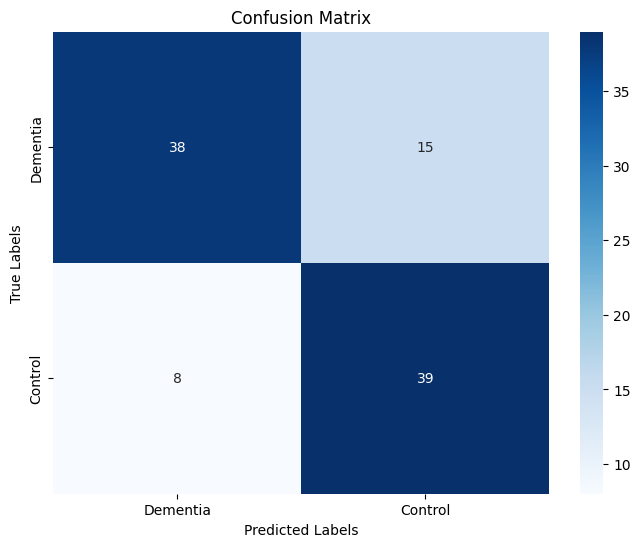

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

# Convert predictions to class indices
preds = np.argmax(preds, axis=1)

# Performance metrics
print(classification_report(test_y, preds, target_names=['Dementia', 'Control']))

# Confusion Matrix
cm = confusion_matrix(test_y, preds)

# Class labels
class_names = ['Dementia', 'Control']

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
